In [1]:

import spacy
import pytextrank
import json
from rake_nltk import Rake
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = "Data Collection/"
dataset_dir = os.path.join(data_dir, "dataset")

In [60]:
# Get all terms from index_terms.json
#  note. this gets all leaves in the json i.e. lowest level terms
term_tree = json.load(open(os.path.join(data_dir, "index_terms.json")))

def get_leafs(term_tree):
    terms = set()
    queue = [term_tree]

    while(queue):
        curr_dict = queue.pop()
        for key in curr_dict:
            if(curr_dict[key]):
                queue.append(curr_dict[key])
            else:
                terms.add(key.lower())
    return terms

terms = get_leafs(term_tree)

In [61]:
def topicRank(text):

# load a spaCy model, depending on language, scale, etc.
    nlp = spacy.load("en_core_web_sm")

    # add PyTextRank to the spaCy pipeline
    nlp.add_pipe("topicrank")
    doc = nlp(text)
    
    tr = doc._.textrank
        
    topics = set()

    for node in tr.node_list:
        for topic in node:
            topics.add(str(topic).lower())
            
    return topics

def rake(text):
    # print(text)
    r = Rake(min_length=1, max_length=8, include_repeated_phrases=False)
    r.extract_keywords_from_text(text)
    ranked_keywords = r.get_ranked_phrases()
    top_keywords = ranked_keywords[:1000000]
    
    keywords = set()
    for keyword in top_keywords:
        keywords.add(str(keyword).lower())
    return keywords

In [62]:
def iou(pred, exp):
    # print(len(exp), len(pred))
    # print(pred, exp)
    return len(pred & exp) / len(pred | exp) * 100

def accuracy(pred, exp):
    return len(pred & exp) / len(exp) * 100

In [80]:
accuracies = {"rake":[], "topicrank":[], "combined":[]}
ious = {"rake":[], "topicrank":[], "combined":[]}

preds = {"rake":[], "topicrank":[], "combined":[]}
ground_truths = []

for doi in os.listdir(dataset_dir):
    text_path = os.path.join(dataset_dir, doi, f"{doi}.txt")
    if(not os.path.exists(text_path)):
        continue
    text = open(text_path, encoding="utf-8", errors="ignore").read()
    
    terms_path = os.path.join(dataset_dir, doi, f"{doi}.json")
    if(not os.path.exists(terms_path)):
        continue
    
    gt_term_tree = json.load(open(terms_path))
    gt_terms = get_leafs(gt_term_tree)
    
    topicRank_topics = topicRank(text)
    topicRank_terms = topicRank_topics.intersection(terms)
    
    rake_topics = rake(text)
    rake_terms = rake_topics.intersection(terms)
    
    combined_terms = topicRank_terms | rake_terms
    
    topicrank_iou = iou(topicRank_terms, gt_terms)
    topicrank_accuracy = accuracy(topicRank_terms, gt_terms)
    print(f"Topic Rank IOU Score: {topicrank_iou}%")
    print(f"Topic Rank Accuracy: {topicrank_accuracy}%")
    
    rake_iou = iou(rake_terms, gt_terms)
    rake_accuracy = accuracy(rake_terms, gt_terms)
    print(f"RAKE IOU Score: {rake_iou}%")
    print(f"RAKE Accuracy: {rake_accuracy}%")
    
    combined_iou = iou(combined_terms, gt_terms)
    combined_accuracy = accuracy(combined_terms, gt_terms)
    print(f"Combined IOU Score: {combined_iou}%")
    print(f"Combined Accuracy: {combined_accuracy}%")
    print()
    
    accuracies['topicrank'].append(topicrank_accuracy)
    ious['topicrank'].append(topicrank_iou)
    
    accuracies['rake'].append(rake_accuracy)
    ious['rake'].append(rake_iou)
    
    accuracies['combined'].append(combined_accuracy)
    ious['combined'].append(combined_iou)
    
    preds['topicrank'].append(topicRank_terms)
    preds['rake'].append(rake_terms)
    preds['combined'].append(combined_terms)
    
    ground_truths.append(gt_terms)

Topic Rank IOU Score: 7.6923076923076925%
Topic Rank Accuracy: 25.0%
RAKE IOU Score: 11.11111111111111%
RAKE Accuracy: 25.0%
Combined IOU Score: 7.6923076923076925%
Combined Accuracy: 25.0%

Topic Rank IOU Score: 0.0%
Topic Rank Accuracy: 0.0%
RAKE IOU Score: 0.0%
RAKE Accuracy: 0.0%
Combined IOU Score: 0.0%
Combined Accuracy: 0.0%

Topic Rank IOU Score: 25.0%
Topic Rank Accuracy: 25.0%
RAKE IOU Score: 25.0%
RAKE Accuracy: 25.0%
Combined IOU Score: 25.0%
Combined Accuracy: 25.0%

Topic Rank IOU Score: 5.714285714285714%
Topic Rank Accuracy: 18.181818181818183%
RAKE IOU Score: 2.941176470588235%
RAKE Accuracy: 9.090909090909092%
Combined IOU Score: 5.405405405405405%
Combined Accuracy: 18.181818181818183%

Topic Rank IOU Score: 0.0%
Topic Rank Accuracy: 0.0%
RAKE IOU Score: 0.0%
RAKE Accuracy: 0.0%
Combined IOU Score: 0.0%
Combined Accuracy: 0.0%

Topic Rank IOU Score: 0.0%
Topic Rank Accuracy: 0.0%
RAKE IOU Score: 0.0%
RAKE Accuracy: 0.0%
Combined IOU Score: 0.0%
Combined Accuracy: 0.0

In [66]:
import numpy as np

In [72]:
for model in accuracies:
    print(f"{model} accruacy: {np.mean(accuracies[model]):.2f}%")
    
print()

for model in ious:
    print(f"{model} IOU: {np.mean(ious[model]):.2f}%")

rake accruacy: 13.58%
topicrank accruacy: 12.96%
combined accruacy: 16.05%

rake IOU: 2.73%
topicrank IOU: 2.78%
combined IOU: 2.80%


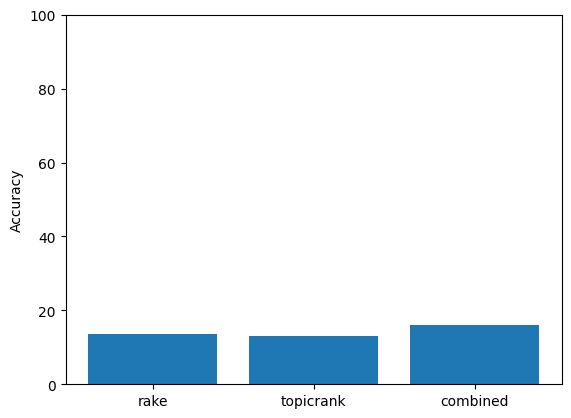

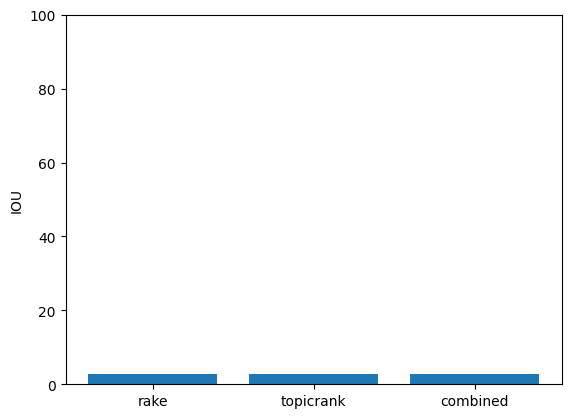

In [79]:
plt.bar(accuracies.keys(), [np.mean(accuracies[key]) for key in accuracies])
plt.ylim((0, 100))
plt.ylabel("Accuracy")
plt.savefig("Keyword_Accuracy_Plot.png")
plt.show()

plt.bar(ious.keys(), [np.mean(ious[key]) for key in ious])
plt.ylim((0, 100))
plt.ylabel("IOU")
plt.savefig("Keyword_IOU_Plot.png")